# ELMo for Aspect-Target Sentiment Classification

В этом ноутбуке мы исследуем применение модели ELMo для решения задачи Aspect-Target Sentiment Classification.

In [1]:
!pip install allennlp
!pip install transformers

     |████████████████████████████████| 7.6MB 2.9MB/s 
     |████████████████████████████████| 30.9MB 99kB/s 
     |████████████████████████████████| 204kB 36.8MB/s 
     |████████████████████████████████| 245kB 44.2MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 163kB 41.0MB/s 
     |████████████████████████████████| 133kB 39.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 256kB 29.6MB/s 
     |████████████████████████████████| 5.2MB 45.9MB/s 
     |████████████████████████████████| 2.1MB 39.6MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 3.2MB 29.0MB/s 
     |████████████████████████████████| 1.0MB 42.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5587 sha256=01ebc6d288927feed0b2362f68a2aa791b53ed6f6a62631b26dd65bf8d5f32bc
  Stored in 

In [2]:
import os
import zipfile
import random

import pandas as pd
import numpy as np
import torch
import gensim
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm

from allennlp.modules.elmo import Elmo, batch_to_ids
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from transformers import AdamW

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Примонтируем наш гугл-диск, если мы решили его использовать.

In [3]:
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/NLP/dialog-sent'
else:
    PATH_PREFIX = '..'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATA_PREFIX = os.path.join(PATH_PREFIX, 'data')
MODEL_PREFIX = os.path.join(PATH_PREFIX, 'models')

Зададим девайс для обучения.

In [5]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


Проинициализируем везде генераторы случайных чисел.

In [0]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

### Данные для англоязычного датасета

Теперь надо разобраться с данными. Мы используем отзывы о рестранах. В каждом отзыве есть т.н. аспектные термины, по которым мы должны указать тональность. В качестве примера можно привести отзыв из датасета:
```xml
<sentence id="1634">
    <text>The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.</text>
    <aspectTerms>
        <aspectTerm term="food" polarity="positive" from="4" to="8"/>
        <aspectTerm term="kitchen" polarity="positive" from="55" to="62"/>
        <aspectTerm term="menu" polarity="neutral" from="141" to="145"/>
    </aspectTerms>
    <aspectCategories>
        <aspectCategory category="food" polarity="positive"/>
    </aspectCategories>
</sentence>
```
Здесь аспектные термины -- это слова food, kitchen, menu. Аттрибуты from, to указывают на позицию термина в предложении.



Данные предоставлены в формате xml. Для работы с ними будем использовать beautiful soup.

In [0]:
def xml2pandas(data_path):
    """Перевод исходного датасета в формате xml в pandas-датафрейм."""
    data_dict = {'sentence_id': [], 'text': [], 'term': [],
                 'from': [], 'to': [], 'sentiment': []}

    with open(data_path, 'r') as inf:
        contents = inf.read()
        soup = bs4.BeautifulSoup(contents, 'xml')
        for sentence in soup.find_all('sentence'):
            # Если нет аспектных терминов
            if sentence.find('aspectTerms') is None:
                continue
            terms = sentence.find('aspectTerms').find_all(
                'aspectTerm'
            )
            for term in terms:
                data_dict['term'].append(term['term'])
                data_dict['from'].append(term['from'])
                data_dict['to'].append(term['to'])
                data_dict['sentiment'].append(term['polarity'])

                data_dict['sentence_id'].append(sentence['id'])
                data_dict['text'].append(sentence.find('text').text)

    data = pd.DataFrame(data_dict)
    data['from'] = data['from'].astype(int)
    data['to'] = data['to'].astype(int)
    return data

In [0]:
data_train_raw_path = os.path.join(
    DATA_PREFIX, 'raw', "SemEval'14-ABSA-TrainData_v2 & AnnotationGuidelines", 
    'Restaurants_Train_v2.xml'
)

data_test_raw_path = os.path.join(
    DATA_PREFIX, 'raw', 'ABSA_Gold_TestData', 'Restaurants_Test_Gold.xml'
)

data_train = xml2pandas(data_train_raw_path)
data_test = xml2pandas(data_test_raw_path)

In [9]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3121,But the staff was so horrible to us.,staff,8,13,negative
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral


In [10]:
data_test.head()

,sentence_id,text,term,from,to,sentiment
0,32897564#894393#2,The bread is top notch as well.,bread,4,9,positive
1,33070600#670328#0,I have to say they have one of the fastest del...,delivery times,43,57,positive
2,33070600#670328#2,Food is always fresh and hot- ready to eat!,Food,0,4,positive
3,36244464#949326#5,Did I mention that the coffee is OUTSTANDING?,coffee,23,29,positive
4,32894246#870052#0,"Certainly not the best sushi in New York, howe...",sushi,23,28,conflict


Теперь, чтобы нормально это обучать надо как-то сохранить информацию о местопложении аспектных терминов (иначе токенизация порушит наши индексы, и они перестанут работать). В общем случае, нам надо хранить слайс индексов, которые будут отвечать за аспектный термин после токенизации.

Чтобы выполнить токенизацию и понять, где все еще находится аспектный термин, нам потребуется поставить какие-то маркеры. Попробуем проверить, что в наших текстах нет символов <, >, которыми мы обозначим границы аспектных терминов.

In [11]:
print(data_train['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())
print(data_test['text'].apply(lambda x: '<' in x).sum())
print(data_test['text'].apply(lambda x: '>' in x).sum())

0
0
0
0


Обрамим аспектные термины символами <<, >>, чтобы потом после токенизации сразу понять, где они.

In [12]:
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3121,But the staff was so horrible to us.,staff,8,13,negative
1,2777,"To be completely fair, the only redeeming fact...",food,57,61,positive
2,1634,"The food is uniformly exceptional, with a very...",food,4,8,positive
3,1634,"The food is uniformly exceptional, with a very...",kitchen,55,62,positive
4,1634,"The food is uniformly exceptional, with a very...",menu,141,145,neutral


In [13]:
!python -m spacy download en_core_web_sm
!python -m spacy validate

     |████████████████████████████████| 11.1MB 4.0MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp36-none-any.whl size=11074435 sha256=9fce4c2221cb2c84ab2629e2a32a6249df6ee52d3213e0523312905040f3f385
  Stored in directory: /tmp/pip-ephem-wheel-cache-49k_ucbh/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.9) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔



In [0]:
nlp = spacy.load("en_core_web_sm")

In [0]:
def tokenize(df_orig, nlp):
    df = df_orig.copy()
    from_tokens = []
    to_tokens = []
    tokenized_texts = []
    for i, row in df.iterrows():
        raw_text = row['text']
        from_index = row['from']
        to_index = row['to']
        text = (raw_text[:from_index] + '< ' + raw_text[from_index:to_index] 
                + ' >' + raw_text[to_index:])
        doc = nlp(text)
        tokens = [x.text for x in doc]
        tokenized_texts.append([x for x in tokens if x not in ['<', '>']])
        try:
            from_tokens.append(tokens.index('<') + 1)
            to_tokens.append(tokens.index('>'))
        except ValueError as e:
            print(raw_text)
            print(tokens)
    df['from'] = from_tokens
    df['to'] = to_tokens
    df['text'] = tokenized_texts
    return df

In [16]:
data_train = tokenize(data_train, nlp)
data_test = tokenize(data_test, nlp)
data_train.head()

,sentence_id,text,term,from,to,sentiment
0,3121,"[But, the, staff, was, so, horrible, to, us, .]",staff,3,4,negative
1,2777,"[To, be, completely, fair, ,, the, only, redee...",food,12,13,positive
2,1634,"[The, food, is, uniformly, exceptional, ,, wit...",food,2,3,positive
3,1634,"[The, food, is, uniformly, exceptional, ,, wit...",kitchen,11,12,positive
4,1634,"[The, food, is, uniformly, exceptional, ,, wit...",menu,28,29,neutral


Проверим, что ничего не сломалось.

In [17]:
print(data_train['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_train['text'].apply(lambda x: '>' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '<' in ''.join(x)).sum())
print(data_test['text'].apply(lambda x: '>' in ''.join(x)).sum())

0
0
0
0


Теперь можем разделить данные на валидацию и трейн.

In [0]:
data_train, data_valid = train_test_split(
    data_train, test_size=0.2, random_state=random_state
)

Будем использовать AllenNLP. В качестве примера будем использовать [официальный сайт](http://docs.allennlp.org/master/tutorials/how_to/elmo/#using-elmo-as-a-pytorch-module-to-train-a-new-model). Можно заметить, что там уже идет обработка батча, поэтому никаким образом паддинги нам обрабатывать не надо, а потому torchtext не нужен.

In [0]:
sentiment_vocab = {'negative': 0, 'positive': 1, 'neutral': 2, 'conflict': 3}

In [0]:
class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, sentiment_vocab):
        self.data = data
        self.sentiment_vocab = sentiment_vocab

    def __getitem__(self, index):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        text = self.data['text'].iloc[index]
        from_index = torch.tensor([self.data['from'].iloc[index]], 
                                  dtype=torch.long)
        to_index = torch.tensor([self.data['to'].iloc[index]], dtype=torch.long)
        sentiment = torch.tensor(
            [self.sentiment_vocab[self.data['sentiment'].iloc[index]]], 
            dtype=torch.long
        )
        return (text, from_index, to_index, sentiment)

    def __len__(self):
        return len(self.data)

In [0]:
def collate_fn(batch):
    """Специальная функция для обработки паддингов."""
    # распакуем батч
    text, from_index, to_index, sentiment = zip(*batch)
    # состакаем все кроме текстов (с ними потом разберется сам ELMo)
    from_index = torch.stack(from_index)
    to_index = torch.stack(to_index)
    sentiment = torch.stack(sentiment)
    return text, from_index, to_index, sentiment

Проверим, что батчи работают правильно.

In [22]:
train_dataset = Dataset(data_train, sentiment_vocab)
dataloader_train = DataLoader(train_dataset, batch_size=5, 
                              shuffle=True, num_workers=4, 
                              collate_fn=collate_fn)

for i_batch, (text_batched, from_batched, to_batched, 
              sentiment_batched) in enumerate(dataloader_train):
    if i_batch == 1:
        break
    print(from_batched)
    print(from_batched.size())

tensor([[ 6],
        [ 7],
        [ 2],
        [13],
        [14]])
torch.Size([5, 1])


### Модель, которая смотрит лишь на сам токен

Зададим архитектуру нашей сети. Надо сразу пояснить некоторые детали. Нашему аспектному термину будет соответствовать несколько токенов, но каждому токену соответствует свой эмбеддинг. Поэтому нам надо как-то саггрегировать эмбеддинги для одного аспектного термина. Я пока предлагаю просто их усреднить.

С точки зрения технической реализации мы будем использовать битову маску, получаемую из индексов from, to.

In [0]:
class ELMOClassifierByToken(nn.Module):

    def __init__(self, num_sentiments, elmo, embeddings_dim, device):
        super(ELMOClassifierByToken, self).__init__()

        self.device = device

        self.elmo = elmo
        self.elmo_layer_coef_1 = nn.Parameter(torch.ones(1))
        self.elmo_layer_coef_2 = nn.Parameter(torch.ones(1))

        self.to_sentiments = nn.Linear(embeddings_dim, num_sentiments)

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.to_sentiments.weight)
        
    def forward(self, texts, from_indices, to_indices, hidden=None):
        # get elmo embeddings
        character_ids = batch_to_ids(texts).to(device=self.device)
        embeddings_raw = self.elmo(character_ids)['elmo_representations']
        embeddings = (
            embeddings_raw[0] * self.elmo_layer_coef_1 
            + embeddings_raw[1] * self.elmo_layer_coef_2
        )

        # get bit matrix
        batch_size, seq_len, _ = embeddings.size()
        index_matrix = torch.repeat_interleave(
            torch.arange(seq_len).view(1, -1), batch_size, dim=0
        ).to(device=self.device)
        bit_matrix = ((index_matrix >= from_indices) 
                      & (index_matrix < to_indices))
        # get average of embedings according to bit_matrix
        embeddings_terms = (torch.sum(embeddings*torch.unsqueeze(bit_matrix, -1), 
                                      dim=1) 
                            / torch.unsqueeze(torch.sum(bit_matrix, dim=1), -1))


        sentiments = self.to_sentiments(embeddings_terms)
        return sentiments

Инициализируем нашу сеть.

In [24]:
set_seed_everywhere(random_seed, USE_GPU)

num_sentiments = len(sentiment_vocab)

options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, 2, dropout=0)

model = ELMOClassifierByToken(
    num_sentiments, elmo, 1024, device
)

100%|██████████| 374434792/374434792 [00:11<00:00, 31572396.56B/s]


#### Тренировочный цикл

Здесь мы реализуем тренировочный цикл для нашей модели.

In [0]:
def train_loop(train_iter, val_iter, model, opt, scheduler, criterion, epochs, 
               early_stopping, path_save, path_best_save, save_every_epoch=5):
    train_losses = []
    val_losses = []
    train_acc_values = []
    val_acc_values = []
    best_val_loss = 100
    best_val_acc = 0
    not_improves = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0.0
        train_acc = 0
        model.train() 
        for batch in tqdm(train_iter, leave=False): 

            texts, from_indices, to_indices, sentiments = batch
            from_indices = from_indices.to(device=device)
            to_indices = to_indices.to(device=device)
            sentiments = sentiments.to(device=device).squeeze(1)

            opt.zero_grad()
            preds = model(texts, from_indices, to_indices)

            loss = criterion(preds, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clipping_value)
            opt.step()
            train_loss += loss.item()

            pred_sentiments = torch.max(preds, dim=-1)[1]
            train_acc += np.sum(
                pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
            )

        train_loss /= len(train_iter.dataset)
        train_losses.append(train_loss)
        train_acc /= len(train_iter.dataset)
        train_acc_values.append(train_acc)

        val_loss = 0.0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for batch in val_iter:

                texts, from_indices, to_indices, sentiments = batch
                from_indices = from_indices.to(device=device)
                to_indices = to_indices.to(device=device)
                sentiments = sentiments.to(device=device).squeeze(1)

                opt.zero_grad()
                preds = model(texts, from_indices, to_indices)

                preds = model(texts, from_indices, to_indices)  
                loss = criterion(preds, sentiments)
                val_loss += loss.item()

                pred_sentiments = torch.max(preds, dim=-1)[1]
                val_acc += np.sum(
                    pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
                )

        val_loss /= len(valid_iter.dataset)
        val_acc /= len(valid_iter.dataset)
        val_losses.append(val_loss)
        val_acc_values.append(val_acc)

        if val_acc > best_val_acc:
            not_improves = 0
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'sheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'validate_losses': val_losses,
                'train_accuracies': train_acc_values,
                'validate_accuracies': val_acc_values,
                }, path_best_save)
            print('------SAVED BEST------')
        else:
            not_improves += 1
            if not_improves == early_stopping:
                break

        if (epoch-1) % save_every_epoch == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'sheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'validate_losses': val_losses,
                'train_accuracies': train_acc_values,
                'validate_accuracies': val_acc_values,
                }, path_save)
            print('------SAVED------')
        
        scheduler.step()

        print(f'Epoch: {epoch}, '
              f'Training Loss*: {1000*train_loss:.3f}, '
              f'Validation Loss*: {1000*val_loss:.3f}, \n'
              f'Training Acc: {train_acc:.3f}, '
              f'Validation Acc: {val_acc:.3f}')

    return train_losses, val_losses, train_acc_values, val_acc_values

In [0]:
remain_sentiments = ['neutral', 'positive', 'negative']

train_dataset = Dataset(
    data_train[data_train.sentiment.isin(remain_sentiments)], 
    sentiment_vocab
)
valid_dataset = Dataset(
    data_valid[data_valid.sentiment.isin(remain_sentiments)], sentiment_vocab
)
test_dataset = Dataset(
    data_test[data_test.sentiment.isin(remain_sentiments)], sentiment_vocab
)

batch_size = 128

train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

valid_iter = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

test_iter = DataLoader(test_dataset, batch_size=batch_size, 
                       shuffle=True, num_workers=4, 
                       collate_fn=collate_fn)

In [0]:
model = model.to(device=device)
learning_rate = 1e-3
early_stopping = 5
grad_clipping_value = 1
epochs = 50

opt = AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=1)
criterion = nn.CrossEntropyLoss()
path_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_by_token.pt')
path_best_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_by_token_best.pt')

In [32]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_acc, val_acc = train_loop(
    train_iter, valid_iter, model, opt, scheduler, criterion, 
    epochs, early_stopping, path_save, path_best_save
)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


------SAVED BEST------
------SAVED------
Epoch: 1, Training Loss*: 8.463, Validation Loss*: 7.176, 
Training Acc: 0.573, Validation Acc: 0.627


------SAVED BEST------
Epoch: 2, Training Loss*: 6.454, Validation Loss*: 6.506, 
Training Acc: 0.655, Validation Acc: 0.671


------SAVED BEST------
Epoch: 3, Training Loss*: 5.722, Validation Loss*: 6.235, 
Training Acc: 0.693, Validation Acc: 0.682


------SAVED BEST------
Epoch: 4, Training Loss*: 5.302, Validation Loss*: 6.058, 
Training Acc: 0.725, Validation Acc: 0.697


------SAVED BEST------
Epoch: 5, Training Loss*: 4.979, Validation Loss*: 6.094, 
Training Acc: 0.741, Validation Acc: 0.702


------SAVED------
Epoch: 6, Training Loss*: 4.732, Validation Loss*: 6.080, 
Training Acc: 0.762, Validation Acc: 0.698


------SAVED BEST------
Epoch: 7, Training Loss*: 4.536, Validation Loss*: 6.182, 
Training Acc: 0.771, Validation Acc: 0.708


------SAVED BEST------
Epoch: 8, Training Loss*: 4.321, Validation Loss*: 6.144, 
Training Acc: 0.787, Validation Acc: 0.716


Epoch: 9, Training Loss*: 4.134, Validation Loss*: 6.127, 
Training Acc: 0.791, Validation Acc: 0.705


Epoch: 10, Training Loss*: 3.980, Validation Loss*: 6.268, 
Training Acc: 0.804, Validation Acc: 0.711


------SAVED------
Epoch: 11, Training Loss*: 3.876, Validation Loss*: 6.673, 
Training Acc: 0.813, Validation Acc: 0.698


Epoch: 12, Training Loss*: 3.789, Validation Loss*: 6.553, 
Training Acc: 0.817, Validation Acc: 0.711


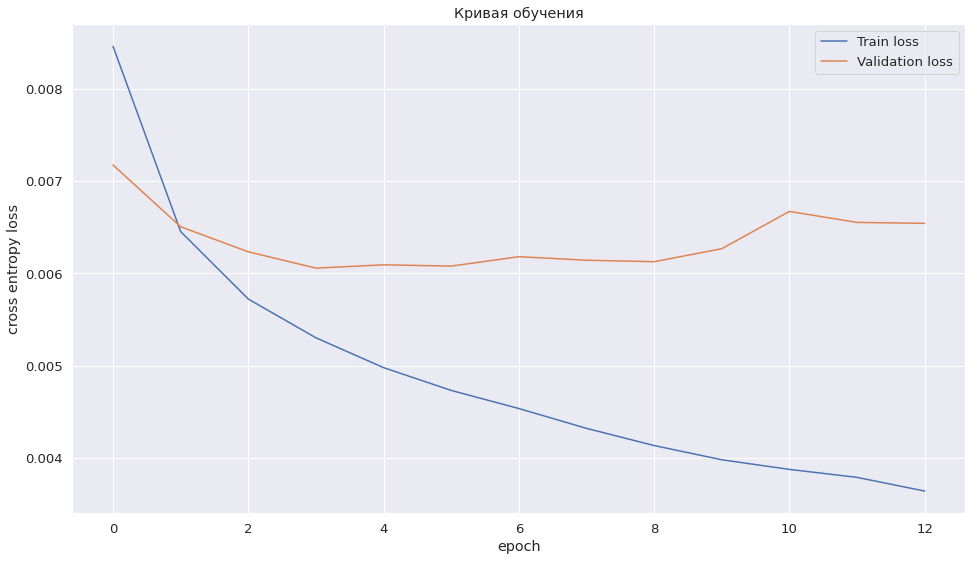

In [33]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

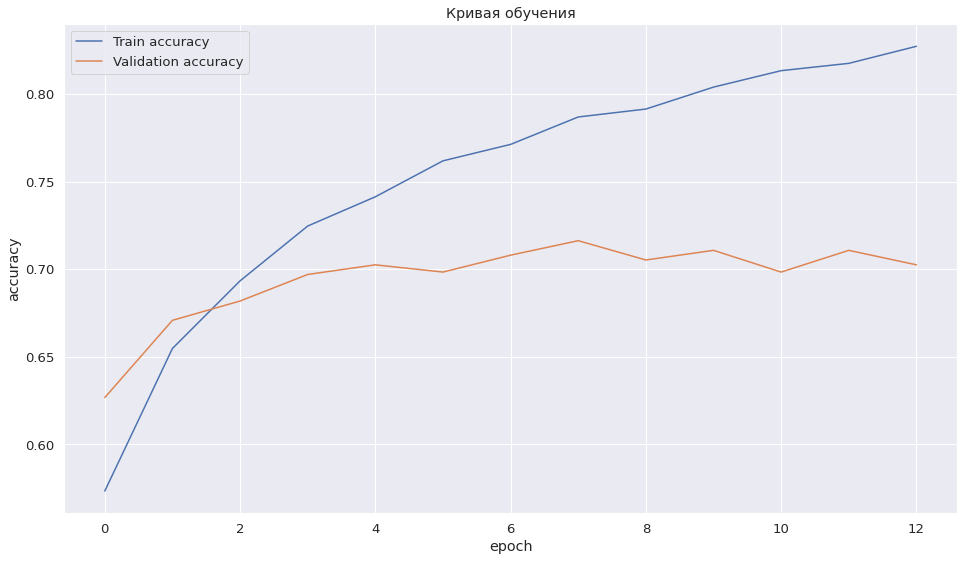

In [34]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_acc, label='Train accuracy')
plt.plot(np.arange(finished_epochs), val_acc, label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Кривая обучения')
plt.legend()
plt.show()

Измерим качество полученной модели.

In [35]:
checkpoint = torch.load(path_best_save)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [36]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        texts, from_indices, to_indices, sentiments = batch
        from_indices = from_indices.to(device=device)
        to_indices = to_indices.to(device=device)
        sentiments = sentiments.to(device=device).squeeze(1)

        preds_scores = model(texts, from_indices, to_indices)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [37]:
accuracy = accuracy_score(all_preds, all_answers)
p_macro,r_macro,f_macro,_ = precision_recall_fscore_support(
    all_answers, all_preds, average='macro'
)

print(f'Accuracy: {accuracy:.3f}')
print(f'MF1: {f_macro:.3f}')

Accuracy: 0.740
MF1: 0.613


По сравнению с результатами [статьи](https://arxiv.org/pdf/1908.11860.pdf) результат пока весьма так себе.

### Модель, которая смотрит на окружение токена

В отличие от прошлой модели теперь мы будем смотреть не на интересующий нас токен, а на все вокруг него. Т.е. теперь замаскированы будут токены, для которых мы оцениваем тональность, а аггрегирующие статистики будут браться по оставшимся токенам. Идея состоит в том, что тональность вполне может содержаться не в самом токене, а в его окружении. В качестве аггрегирующих статистик попробуем взять: average-pooling, max-pooling.

In [0]:
class ELMOClassifierByContext(nn.Module):

    def __init__(self, num_sentiments, elmo, embeddings_dim, device):
        super(ELMOClassifierByContext, self).__init__()

        self.device = device

        self.elmo = elmo
        self.elmo_layer_coef_1 = nn.Parameter(torch.ones(1))
        self.elmo_layer_coef_2 = nn.Parameter(torch.ones(1))

        self.to_sentiments = nn.Linear(2*embeddings_dim, num_sentiments)

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.to_sentiments.weight)
        
    def forward(self, texts, from_indices, to_indices, hidden=None):
        # get elmo embeddings
        character_ids = batch_to_ids(texts).to(device=self.device)
        embeddings_raw = self.elmo(character_ids)['elmo_representations']
        embeddings = (
            embeddings_raw[0] * self.elmo_layer_coef_1 
            + embeddings_raw[1] * self.elmo_layer_coef_2
        )

        # get bit matrix
        batch_size, seq_len, _ = embeddings.size()
        index_matrix = torch.repeat_interleave(
            torch.arange(seq_len).view(1, -1), batch_size, dim=0
        ).to(device=self.device)
        bit_matrix = ((index_matrix >= from_indices) 
                      & (index_matrix < to_indices))
        # inverse bit matrix to work with context
        bit_matrix = ~bit_matrix
        # get average of embedings according to bit_matrix
        context_average = (torch.sum(embeddings*torch.unsqueeze(bit_matrix, -1), 
                                      dim=1) 
                            / torch.unsqueeze(torch.sum(bit_matrix, dim=1), -1))
        
        context_max = torch.max(embeddings*torch.unsqueeze(bit_matrix, -1), 
                                dim=1)[0]
        
        context_representation = torch.cat([context_average, context_max], 
                                           dim=-1)

        sentiments = self.to_sentiments(context_representation)
        return sentiments

Инициализируем нашу сеть.

In [0]:
set_seed_everywhere(random_seed, USE_GPU)

num_sentiments = len(sentiment_vocab)

options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, 2, dropout=0)

model = ELMOClassifierByContext(
    num_sentiments, elmo, 1024, device
)

#### Обучение

In [0]:
remain_sentiments = ['neutral', 'positive', 'negative']

train_dataset = Dataset(
    data_train[data_train.sentiment.isin(remain_sentiments)], 
    sentiment_vocab
)
valid_dataset = Dataset(
    data_valid[data_valid.sentiment.isin(remain_sentiments)], sentiment_vocab
)
test_dataset = Dataset(
    data_test[data_test.sentiment.isin(remain_sentiments)], sentiment_vocab
)

batch_size = 128

train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

valid_iter = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

test_iter = DataLoader(test_dataset, batch_size=batch_size, 
                       shuffle=True, num_workers=4, 
                       collate_fn=collate_fn)

In [0]:
model = model.to(device=device)
learning_rate = 1e-3
early_stopping = 5
grad_clipping_value = 1
epochs = 50

opt = AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=1)
criterion = nn.CrossEntropyLoss()
path_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_by_context.pt')
path_best_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_by_context_best.pt')

In [42]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_acc, val_acc = train_loop(
    train_iter, valid_iter, model, opt, scheduler, criterion, 
    epochs, early_stopping, path_save, path_best_save
)



------SAVED BEST------
------SAVED------
Epoch: 1, Training Loss*: 9.176, Validation Loss*: 7.274, 
Training Acc: 0.541, Validation Acc: 0.607


------SAVED BEST------
Epoch: 2, Training Loss*: 6.617, Validation Loss*: 6.371, 
Training Acc: 0.652, Validation Acc: 0.675


Epoch: 3, Training Loss*: 6.117, Validation Loss*: 6.578, 
Training Acc: 0.673, Validation Acc: 0.656


Epoch: 4, Training Loss*: 5.653, Validation Loss*: 6.306, 
Training Acc: 0.699, Validation Acc: 0.661


Epoch: 5, Training Loss*: 5.556, Validation Loss*: 6.735, 
Training Acc: 0.706, Validation Acc: 0.656


------SAVED------
Epoch: 6, Training Loss*: 5.635, Validation Loss*: 6.678, 
Training Acc: 0.691, Validation Acc: 0.656


------SAVED BEST------
Epoch: 7, Training Loss*: 5.301, Validation Loss*: 6.142, 
Training Acc: 0.718, Validation Acc: 0.685


------SAVED BEST------
Epoch: 8, Training Loss*: 4.978, Validation Loss*: 5.743, 
Training Acc: 0.732, Validation Acc: 0.693


Epoch: 9, Training Loss*: 4.968, Validation Loss*: 6.547, 
Training Acc: 0.738, Validation Acc: 0.674


Epoch: 10, Training Loss*: 4.794, Validation Loss*: 6.261, 
Training Acc: 0.764, Validation Acc: 0.693


------SAVED BEST------
------SAVED------
Epoch: 11, Training Loss*: 4.687, Validation Loss*: 5.897, 
Training Acc: 0.756, Validation Acc: 0.719


Epoch: 12, Training Loss*: 4.503, Validation Loss*: 5.993, 
Training Acc: 0.769, Validation Acc: 0.700


Epoch: 13, Training Loss*: 4.598, Validation Loss*: 6.411, 
Training Acc: 0.763, Validation Acc: 0.683


Epoch: 14, Training Loss*: 4.255, Validation Loss*: 6.252, 
Training Acc: 0.777, Validation Acc: 0.665


Epoch: 15, Training Loss*: 4.325, Validation Loss*: 5.878, 
Training Acc: 0.778, Validation Acc: 0.719


------SAVED BEST------
------SAVED------
Epoch: 16, Training Loss*: 4.072, Validation Loss*: 5.886, 
Training Acc: 0.790, Validation Acc: 0.720


Epoch: 17, Training Loss*: 4.137, Validation Loss*: 6.003, 
Training Acc: 0.788, Validation Acc: 0.713


Epoch: 18, Training Loss*: 3.966, Validation Loss*: 5.835, 
Training Acc: 0.796, Validation Acc: 0.711


Epoch: 19, Training Loss*: 3.881, Validation Loss*: 6.129, 
Training Acc: 0.803, Validation Acc: 0.687


Epoch: 20, Training Loss*: 3.845, Validation Loss*: 6.194, 
Training Acc: 0.807, Validation Acc: 0.719


------SAVED BEST------
------SAVED------
Epoch: 21, Training Loss*: 3.993, Validation Loss*: 5.883, 
Training Acc: 0.796, Validation Acc: 0.734


Epoch: 22, Training Loss*: 3.573, Validation Loss*: 5.866, 
Training Acc: 0.821, Validation Acc: 0.709


Epoch: 23, Training Loss*: 3.575, Validation Loss*: 5.942, 
Training Acc: 0.814, Validation Acc: 0.723


Epoch: 24, Training Loss*: 3.413, Validation Loss*: 6.172, 
Training Acc: 0.833, Validation Acc: 0.711


Epoch: 25, Training Loss*: 3.799, Validation Loss*: 6.768, 
Training Acc: 0.804, Validation Acc: 0.652


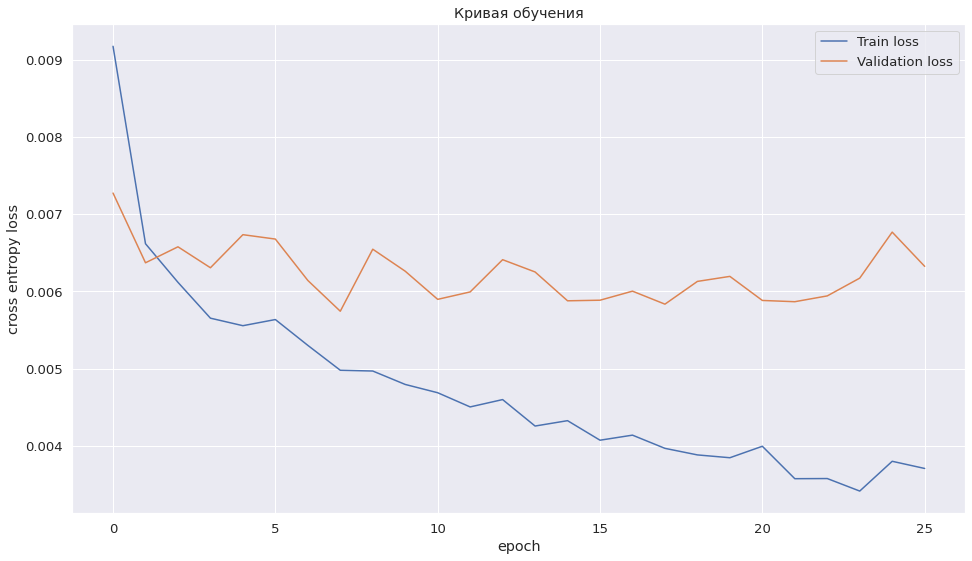

In [48]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

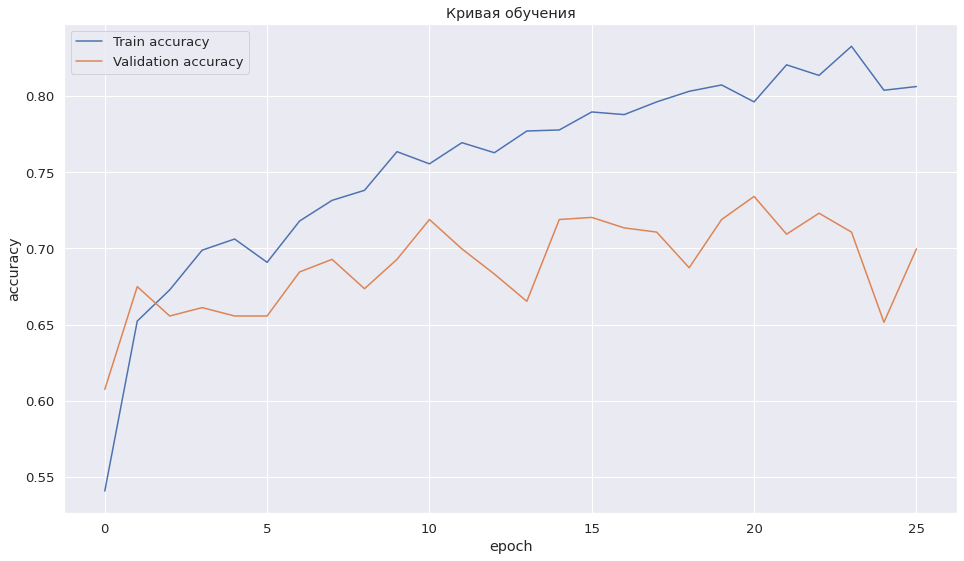

In [49]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_acc, label='Train accuracy')
plt.plot(np.arange(finished_epochs), val_acc, label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Кривая обучения')
plt.legend()
plt.show()

Измерим качество полученной модели.

In [50]:
checkpoint = torch.load(path_best_save)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        texts, from_indices, to_indices, sentiments = batch
        from_indices = from_indices.to(device=device)
        to_indices = to_indices.to(device=device)
        sentiments = sentiments.to(device=device).squeeze(1)

        preds_scores = model(texts, from_indices, to_indices)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [52]:
accuracy = accuracy_score(all_preds, all_answers)
p_macro,r_macro,f_macro,_ = precision_recall_fscore_support(
    all_answers, all_preds, average='macro'
)

print(f'Accuracy: {accuracy:.3f}')
print(f'MF1: {f_macro:.3f}')

Accuracy: 0.729
MF1: 0.618


Результаты не лучше, чем в прошлый раз. От запуска к с различными параметрами варьируется, но принципиально лучше не становится.

### CNN по окружению

Чуть усложним идею из предыдущего пункта и попробуем применить пару сверток.

In [0]:
class ELMOCNN(nn.Module):

    def __init__(self, num_sentiments, elmo, embeddings_dim, 
                 hidden_dim, kernel_sizes,
                 device):
        super(ELMOCNN, self).__init__()

        self.device = device

        self.elmo = elmo
        self.elmo_layer_coef_1 = nn.Parameter(torch.ones(1))
        self.elmo_layer_coef_2 = nn.Parameter(torch.ones(1))

        self.convs1 = nn.ModuleList(
            [nn.Conv1d(embeddings_dim, hidden_dim, kernel_size) 
            for kernel_size in kernel_sizes]
        )
        self.convs1_nonlin = nn.ReLU()
        self.convs1_dropout = nn.Dropout()

        self.to_sentiments = nn.Linear(2*len(kernel_sizes)*hidden_dim, 
                                       num_sentiments)

        # weights initializatioin
        torch.nn.init.xavier_uniform_(self.to_sentiments.weight)
        
    def forward(self, texts, from_indices, to_indices, hidden=None):
        # get elmo embeddings
        character_ids = batch_to_ids(texts).to(device=self.device)
        embeddings_raw = self.elmo(character_ids)['elmo_representations']
        embeddings = (
            embeddings_raw[0] * self.elmo_layer_coef_1 
            + embeddings_raw[1] * self.elmo_layer_coef_2
        )

        # get bit matrix
        batch_size, seq_len, _ = embeddings.size()
        index_matrix = torch.repeat_interleave(
            torch.arange(seq_len).view(1, -1), batch_size, dim=0
        ).to(device=self.device)
        bit_matrix = ((index_matrix >= from_indices) 
                      & (index_matrix < to_indices))
        # inverse bit matrix to work with context
        bit_matrix = ~bit_matrix
        # get average of embedings according to bit_matrix
        embeddings = embeddings*torch.unsqueeze(bit_matrix, -1)
        embeddings = torch.transpose(embeddings, 1, 2)
        x = [self.convs1_nonlin(conv(embeddings)) for conv in self.convs1]

        list_to_cat = [torch.max(y, 2)[0] for y in x]
        list_to_cat += [torch.mean(y, 2) for y in x]
        x = torch.cat(list_to_cat, 1)
        x = self.convs1_dropout(x)
        sentiments = self.to_sentiments(x)
        return sentiments

Инициализируем нашу сеть.

In [0]:
set_seed_everywhere(random_seed, USE_GPU)

num_sentiments = len(sentiment_vocab)

options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, 2, dropout=0)

hidden_dim = 32

model = ELMOCNN(
    num_sentiments, elmo, 1024, hidden_dim, [3, 5, 7], device
)

#### Обучение

In [0]:
remain_sentiments = ['neutral', 'positive', 'negative']

train_dataset = Dataset(
    data_train[data_train.sentiment.isin(remain_sentiments)], 
    sentiment_vocab
)
valid_dataset = Dataset(
    data_valid[data_valid.sentiment.isin(remain_sentiments)], sentiment_vocab
)
test_dataset = Dataset(
    data_test[data_test.sentiment.isin(remain_sentiments)], sentiment_vocab
)

batch_size = 128

train_iter = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

valid_iter = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4, 
                        collate_fn=collate_fn)

test_iter = DataLoader(test_dataset, batch_size=batch_size, 
                       shuffle=True, num_workers=4, 
                       collate_fn=collate_fn)

In [0]:
model = model.to(device=device)
learning_rate = 5*1e-4
early_stopping = 6
grad_clipping_value = 1
l2_reg = 1e-3
epochs = 50

opt = AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=1)
criterion = nn.CrossEntropyLoss()
path_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_cnn.pt')
path_best_save = os.path.join(MODEL_PREFIX, 'elmo', 'elmo_cnn_best.pt')

In [202]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_acc, val_acc = train_loop(
    train_iter, valid_iter, model, opt, scheduler, criterion, 
    epochs, early_stopping, path_save, path_best_save
)


------SAVED BEST------
------SAVED------
Epoch: 1, Training Loss*: 7.358, Validation Loss*: 5.718, 
Training Acc: 0.624, Validation Acc: 0.722


------SAVED BEST------
Epoch: 2, Training Loss*: 4.902, Validation Loss*: 5.230, 
Training Acc: 0.752, Validation Acc: 0.751


Epoch: 3, Training Loss*: 4.297, Validation Loss*: 5.135, 
Training Acc: 0.798, Validation Acc: 0.747


------SAVED BEST------
Epoch: 4, Training Loss*: 3.448, Validation Loss*: 5.020, 
Training Acc: 0.834, Validation Acc: 0.762


Epoch: 5, Training Loss*: 2.911, Validation Loss*: 5.251, 
Training Acc: 0.863, Validation Acc: 0.745


------SAVED------
Epoch: 6, Training Loss*: 2.572, Validation Loss*: 5.596, 
Training Acc: 0.886, Validation Acc: 0.755


Epoch: 7, Training Loss*: 2.128, Validation Loss*: 5.297, 
Training Acc: 0.901, Validation Acc: 0.759


Epoch: 8, Training Loss*: 1.890, Validation Loss*: 5.460, 
Training Acc: 0.913, Validation Acc: 0.760


------SAVED BEST------
Epoch: 9, Training Loss*: 1.767, Validation Loss*: 5.380, 
Training Acc: 0.919, Validation Acc: 0.766


Epoch: 10, Training Loss*: 1.477, Validation Loss*: 5.638, 
Training Acc: 0.939, Validation Acc: 0.766


------SAVED BEST------
------SAVED------
Epoch: 11, Training Loss*: 1.347, Validation Loss*: 5.845, 
Training Acc: 0.943, Validation Acc: 0.770


------SAVED BEST------
Epoch: 12, Training Loss*: 1.385, Validation Loss*: 5.788, 
Training Acc: 0.942, Validation Acc: 0.771


Epoch: 13, Training Loss*: 1.204, Validation Loss*: 6.054, 
Training Acc: 0.955, Validation Acc: 0.770


Epoch: 14, Training Loss*: 0.986, Validation Loss*: 5.966, 
Training Acc: 0.960, Validation Acc: 0.771


------SAVED BEST------
Epoch: 15, Training Loss*: 0.921, Validation Loss*: 6.148, 
Training Acc: 0.963, Validation Acc: 0.775


------SAVED BEST------
------SAVED------
Epoch: 16, Training Loss*: 0.898, Validation Loss*: 5.952, 
Training Acc: 0.965, Validation Acc: 0.780


Epoch: 17, Training Loss*: 0.798, Validation Loss*: 6.304, 
Training Acc: 0.968, Validation Acc: 0.775


Epoch: 18, Training Loss*: 0.614, Validation Loss*: 6.746, 
Training Acc: 0.974, Validation Acc: 0.778


Epoch: 19, Training Loss*: 0.726, Validation Loss*: 6.355, 
Training Acc: 0.973, Validation Acc: 0.774


Epoch: 20, Training Loss*: 0.651, Validation Loss*: 7.061, 
Training Acc: 0.978, Validation Acc: 0.774


------SAVED------
Epoch: 21, Training Loss*: 0.773, Validation Loss*: 7.079, 
Training Acc: 0.969, Validation Acc: 0.766


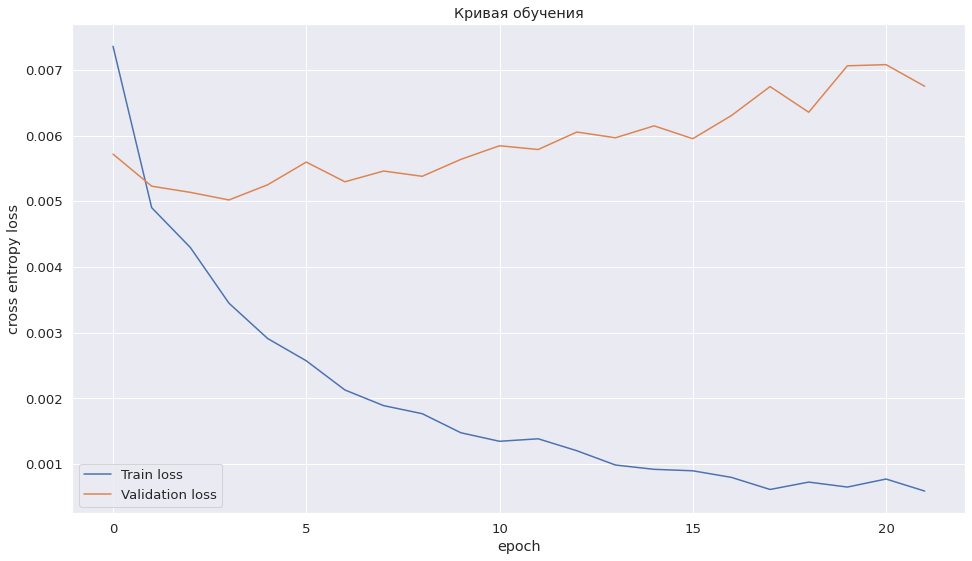

In [208]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Кривая обучения')
plt.legend()
plt.show()

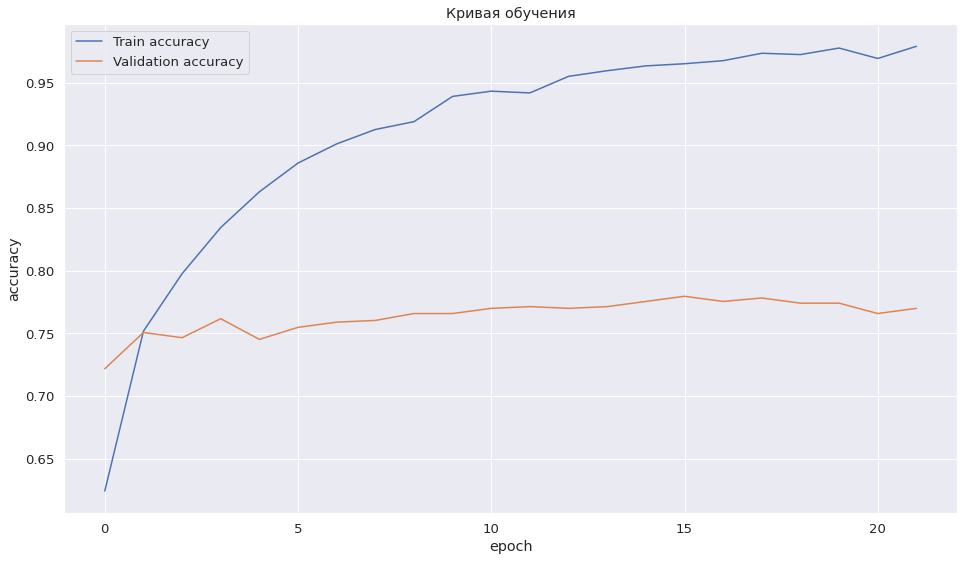

In [209]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_acc, label='Train accuracy')
plt.plot(np.arange(finished_epochs), val_acc, label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Кривая обучения')
plt.legend()
plt.show()

Измерим качество полученной модели.

In [210]:
checkpoint = torch.load(path_best_save)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [0]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        texts, from_indices, to_indices, sentiments = batch
        from_indices = from_indices.to(device=device)
        to_indices = to_indices.to(device=device)
        sentiments = sentiments.to(device=device).squeeze(1)

        preds_scores = model(texts, from_indices, to_indices)
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()

all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [212]:
accuracy = accuracy_score(all_preds, all_answers)
p_macro,r_macro,f_macro,_ = precision_recall_fscore_support(
    all_answers, all_preds, average='macro'
)

print(f'Accuracy: {accuracy:.3f}')
print(f'MF1: {f_macro:.3f}')

Accuracy: 0.807
MF1: 0.707


Эта модель работает уже лучше, чем предыдущие. В процессе экспериментов была добавлена l2-регуляризация. Также пробовались другие размеры out_channels, но в итоге лучше результаты получались с `hidden_dim=32`.

### Выводы

1. Пока лучшей оказалась модель ELMOCNN. Отсюда следует, что, возможно, имеет смысл еще с ней поэкспериментировать.


### Что можно сделать
1. Попробовать Attention. Входом для него использовать усредненный целевой токен. В итоге получим взвешенные токены исходного предложений, по которым можно сделать pooling. (А вдруг можно их тоже через CNN пропустить?).